In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

# <center>Computational Mathematics Report</center>
### <center>Donato Meoli</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard with Machine Learning</center>

## Abstract

**OptiML**, for what about the ***opti*** module, is a collection of the most successful optimization algorithms, both *constrained* and *unconstrained*, used in the machine learning context. To investigate its behavior we will refer to a learning model known as *Support Vector Machine* for which its *primal* and *dual* (mathematically equivalents) formulations give rise to an unconstrained and constrained optimization problem respectively.

This work was motivated also by the desire to highlight the strengths and weaknesses of the two formulations for which it is known that the first one, the primal formulation, is suitable for large linear training since the complexity of the model grows with the number of features or, more in general, when the number of examples $n$ is much larger than the number of features $m$, $n >> m$; while the last one, the dual formulation, is more suitable in case the number of examples $n$ is less than the number of features $m$, $n < m$, since the complexity of the model is dominated by the number of examples.

## Support Vector Machines

A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification or regression. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier.

### Support Vector Classifier

#### Linearly Separable Binary Classification

Given $n$ training points, where each input $x_i$ has $m$ attributes (i.e., is of dimensionality $m$) and is in one of two classes $y_{i}=\pm1$, i.e our training data is of the form:

$$
\{x_i,y_{i}\} \ \text{where} \ i=1, \dots, n, x_i\in\Re^{m}, y_{i}\in\{+1,-1\}
$$

we assume the data is linearly separable, meaning that we can draw a line on a graph of $x_{1}$ vs $x_{2}$ separating the two classes when $m=2$ and a hyperplane on graphs of $x_{1}, x_{2}$, $\dots$, $x_{m}$ for when $m>2$.

This hyperplane can be described by $\langle w, x \rangle +b=0$ where $w$ is normal to the hyperplane and $\displaystyle \frac{b}{\Vert w\Vert}$ is the perpendicular distance from the hyperplane to the origin.

Support vectors are the examples closest to the separating hyperplane and the aim of support vector machines is to orientate this hyperplane in such a way as to be as far as possible from the closest members of both classes.

<img src="./img/svc_hard.png" width=600/>

Referring to this figure, implementing a SVM boils down to selecting the variables $w$ and $b$ so that our training data can be described by:

$$
\begin{equation}
    \langle w, x_i \rangle +b\geq+1 \ \text{for} \ y_{i}=+1 \tag{1.1}
\end{equation}
$$
$$
\begin{equation}
    \langle w, x_i \rangle +b\leq-1 \ \text{for} \ y_{i}=-1 \tag{1.2}
\end{equation}
$$ 

These equations can be combined into:

$$
\begin{equation}
    y_{i}(\langle w, x_i \rangle +b) \geq 1 \ \forall_{i} \tag{1.3}
\end{equation}
$$ 

If we now just consider the points that lie closest to the separating hyperplane, i.e., the Support Vectors (shown in circles in the diagram), then the two planes $H_{1}$ and $H_{2}$ that these points lie on can be described by:

$$
\begin{equation}
    \langle w, x_i \rangle +b=+1 \ \text{for} \ H_{1} \tag{1.4}
\end{equation}
$$ 
$$
\begin{equation}
    \langle w, x_i \rangle +b=-1 \ \text{for} \ H_{2} \tag{1.5}
\end{equation}
$$ 

Referring to the previous figure, we define $d_{1}$ as being the distance from $H_{1}$ to the hyperplane and $d_{2}$ from $H_{2}$ to it. The hyperplane's equidistance from $H_{1}$ and $H_{2}$ means that $d_{1}=d_{2}-$ a quantity known as the SVM's margin. In order to orientate the hyperplane to be as far from the Support Vectors as possible, we need to maximize this margin.

Simple vector geometry shows that the margin is equal to $\displaystyle \frac{1}{\Vert w\Vert}$ and maximizing it subject to the constraint in (1.3) is equivalent to finding:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b} \quad & \Vert w \Vert \\
            \textrm{subject to} \quad & y_{i}(\langle w, x_i \rangle +b) \geq 1 \ \forall_{i}
    \end{aligned} \tag{1.6}
\end{equation}
$$

Minimizing $\Vert w\Vert$ is equivalent to minimizing $\displaystyle \frac{1}{2}\Vert w\Vert^{2}$, so we need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b} \quad & \frac{1}{2} \Vert w \Vert^2 \\
            \textrm{subject to} \quad & y_{i}(\langle w, x_i \rangle +b) \geq 1 \ \forall_{i}
    \end{aligned} \tag{1.7}
\end{equation}
$$

which can be equivalently formulated as: 

$$
\begin{equation}
    \min_{w,b} \frac{1}{2} \Vert w \Vert^2 +
        \begin{cases}
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b)) & \text{if using L1 loss} \\
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b))^2 & \text{if using L2 loss}
          \end{cases} \tag{1.8}
\end{equation}
$$

where we make use of the Hinge (L1 loss) and squared Hinge (L2 loss) loss respectively.

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.5037 - val_acc:  0.2000
  50	  50	 3.6358e-02 - val_loss:  6.1284e-02 - acc:  1.0000 - val_acc:  1.0000
 100	 100	 2.3251e-02 - val_loss:  5.2549e-02 - acc:  1.0000 - val_acc:  1.0000
 150	 150	 1.8124e-02 - val_loss:  4.9704e-02 - acc:  1.0000 - val_acc:  1.0000
 200	 200	 1.5725e-02 - val_loss:  5.4323e-02 - acc:  1.0000 - val_acc:  1.0000
 250	 250	 1.4058e-02 - val_loss:  5.8322e-02 - acc:  1.0000 - val_acc:  1.0000
 300	 300	 1.3474e-02 - val_loss:  6.0861e-02 - acc:  1.0000 - val_acc:  1.0000
 350	 350	 1.3063e-02 - val_loss:  6.3066e-02 - acc:  1.0000 - val_acc:  1.0000
 400	 400	 1.2975e-02 - val_loss:  6.4123e-02 - acc:  1.0000 - val_acc:  1.0000
 450	 450	 1.2890e-02 - val_loss:  6.5180e-02 - acc:  1.0000 - val_acc:  1.0000
 500	 500	 1.2806e-02 - val_loss:  6.6214e-02 - acc:  1.0000 - val_acc:  1.0000
 550	 550	 1.2726e-02 - val_loss:  6.7239e-02 - acc:  1.0000 - val_acc:  1.0000
 600	 600	 1.2650e-02 

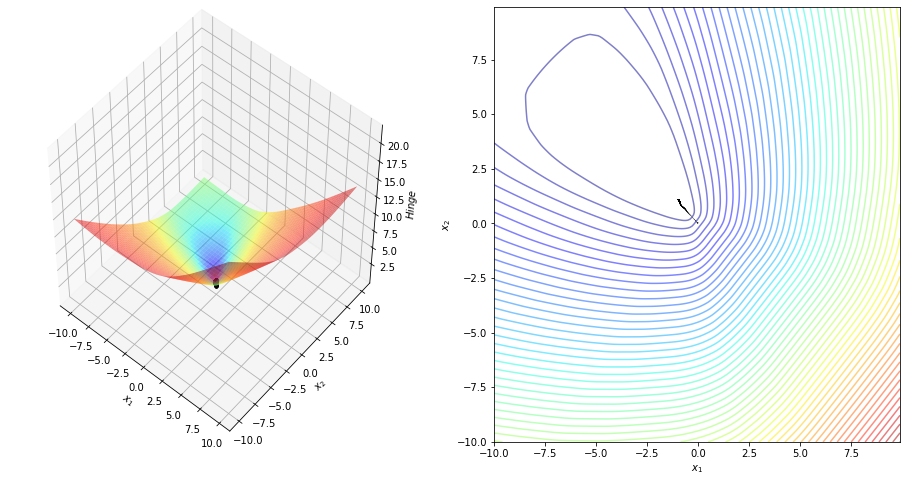

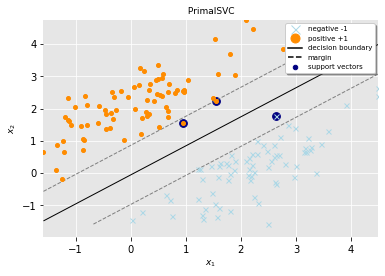

svc accuracy score is 1.0
svc w is [-0.98293353  1.09139466]
svc b is 0.06300497479421141

sklearn CPU times: user 559 µs, sys: 208 µs, total: 767 µs
Wall time: 546 µs


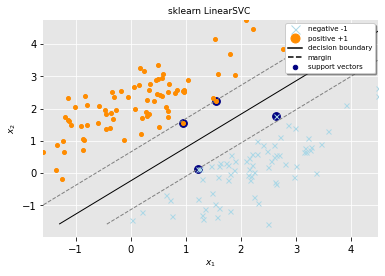

sklearn svc accuracy score is 1.0
sklearn svc w is [[-1.15608573  1.11886419]]
sklearn svc b is [0.27090545]


In [2]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import generate_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SKLinearSVC
from sklearn.model_selection import train_test_split

X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
%time svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='hinge')
print('sklearn ', end='')
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In order to cater for the constraints in this minimization, we need to allocate them Lagrange multipliers $\alpha$, where $\alpha_{i}\geq 0 \ \forall_{i}$:

$$
\begin{align*}
    \mathcal{L}(w,b,\alpha) \displaystyle &= \frac{1}{2}\Vert w\Vert^{2}-\alpha[y_{i}(\langle w, x_i \rangle +b)-1 \ \forall_{i}] \tag{1.9} \\
    &= \displaystyle \frac{1}{2}\Vert w\Vert^{2}-\sum_{i=1}^{n}\alpha_{i}[y_{i}(\langle w, x_i \rangle +b)-1] \tag{1.10} \\
    &= \displaystyle \frac{1}{2}\Vert w\Vert^{2}-\sum_{i=1}^{n}\alpha_{i}y_{i}(\langle w, x_i \rangle +b)+\sum_{i=1}^{n}\alpha_{i} \tag{1.11}
\end{align*}
$$

We wish to find the $w$ and $b$ which minimizes, and the $\alpha$ which maximizes $\mathcal{L}$ (whilst keeping $\alpha_{i}\geq 0 \ \forall_{i}$). We can do this by differentiating $\mathcal{L}$ with respect to $w$ and $b$ and setting the derivatives to zero:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{L}}{\partial w}=0\Rightarrow w=\sum_{i=1}^{n}\alpha_{i}y_i x_i \tag{1.12}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{L}}{\partial b}=0\Rightarrow\sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{1.13}
\end{equation}
$$

Substituting (1.12) and (1.13) into (1.11) gives a new formulation which, being dependent on $\alpha$, we need to maximize:

$$
\begin{align*}
    L_{D}\displaystyle &= \sum_{i=1}^{n}\alpha_{i} - \frac{1}{2}\sum_{i,j}\alpha_{i}\alpha_{j}y_{i}y_{j} \langle x_i, x_j \rangle \ \text{subject to} \ \alpha_{i}\geq 0 \ \forall_{i}, \displaystyle \sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{1.14} \\
    &= \displaystyle \sum_{i=1}^{n}\alpha_{i} - \frac{1}{2}\sum_{i,j}\alpha_{i}Q_{ij}\alpha_{j} \ \text{where} \ Q_{ij} = y_{i}y_{j} \langle x_{i}, x_{j} \rangle \tag{1.15} \\
    &= \sum_{i=1}^{n}\alpha_{i} - \frac{1}{2}\alpha^{T}Q\alpha \ \text{subject to} \ \alpha_{i}\geq 0 \ \forall_{i}, \displaystyle \sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{1.16}
\end{align*}
$$

This new formulation $L_{D}$ is referred to as the *Wolfe dual* form of the *primary* formulation. It is worth noting that the dual form requires only the dot product of each input vector $x_{i}$ to be calculated, this is important for the *kernel trick* discussed later.

Having moved from minimizing $\mathcal{L}$ to maximizing $L_{D}$, we need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha} \quad & \frac{1}{2} \alpha^{T}Q\alpha-q^T\alpha \\
            \textrm{subject to} \quad & \alpha_{i}\geq 0 \ \forall_{i} \\ & y^T\alpha=0
    \end{aligned} \tag{1.17}
\end{equation}
$$

where $q$ is a vector of all ones.

This is a convex quadratic optimization problem, and we run a QP solver which will return $\alpha$ and from (1.12) will give us $w$. What remains is to calculate $b.$

Any data point satisfying (1.13) which is a Support Vector $x_{s}$ will have the form:

$$y_{s}(\langle w, x_{s} \rangle +b)=1$$

Substituting in (1.12):

$$y_{s}(\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle +b)=1$$

Where $S$ denotes the set of indices of the support vectors. $S$ is determined by finding the indices $i$ where $\alpha_{i}>0$. Multiplying through by $y_{s}$ and then using $y_{s}^{2}=1$ from (1.1) and (1.2):

$$y_{s}^{2}(\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle +b)=y_{s}$$
$$b=y_{s}-\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle$$

Instead of using an arbitrary support vector $x_{s}$, it is better to take an average over all of the support vectors in $S$:

$$
\begin{equation}
    b=\displaystyle \frac{1}{N_{s}}\sum_{s\in S}(y_{s}-\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle) \tag{1.18}
\end{equation}
$$

We now have the variables $w$ and $b$ that define our separating hyperplane's optimal orientation and hence our support vector machine. Each new point $x'$ is classified by evaluating:

$$
\begin{equation}
    y'=\displaystyle \operatorname{sgn}(\sum_{i=1}^{n}\alpha_i y_i\langle x_{i}, x' \rangle+b) \tag{1.19}
\end{equation}
$$

iter	 cost
   0	-1.3749e+00
   1	-1.8253e+00
   2	-1.9297e+00
   3	-1.9716e+00
   4	-2.0243e+00
   5	-2.0608e+00
   6	-2.0771e+00
   7	-2.0874e+00
   8	-2.0944e+00
   9	-2.1014e+00
  10	-2.1128e+00
  11	-2.1212e+00
  12	-2.1212e+00
  13	-2.1212e+00
  14	-2.1212e+00

CPU times: user 69.7 ms, sys: 93.9 ms, total: 164 ms
Wall time: 31.1 ms


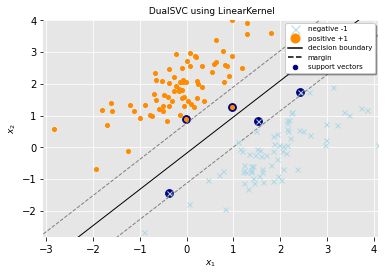

svc accuracy score is 1.0
svc found 5 support vectors from 150 examples
svc w is [-1.20337597  1.05529455]
svc b is 0.19569340668646448

sklearn CPU times: user 2.94 ms, sys: 0 ns, total: 2.94 ms
Wall time: 2.63 ms


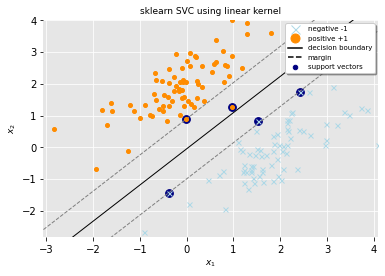

sklearn svc accuracy score is 1.0
sklearn svc found 5 support vectors from 150 examples
sklearn svc w is [[-1.20456245  1.05633498]]
sklearn svc b is [0.05100225]


In [4]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='linear')
print('sklearn ', end='')
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

epoch	iter	 cost	
   0	   0	-1.1065e+14	ub: -1.1065e+14 - pcost: -5.4366e+03 - gap:  1.0000e+00

CPU times: user 138 ms, sys: 157 ms, total: 296 ms
Wall time: 39.6 ms


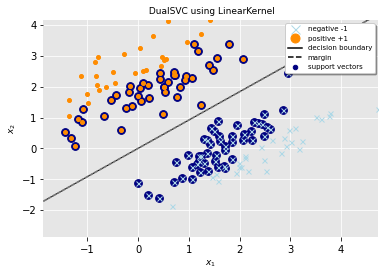

svc accuracy score is 1.0
svc found 94 support vectors from 150 examples
svc w is [-71.16884938  77.4346087 ]
svc b is -0.13969237782831917


In [2]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, optimizer=AdaGrad, verbose=50)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

#### Nonlinearly Separable Binary Classification

In order to extend the SVM methodology to handle data that is not fully linearly separable, we relax the constraints for (1.1) and (1.2) slightly to allow for misclassified points. This is done by introducing a positive slack variable $\xi_{i}, i=1$, $\dots$, $n$ :

$$
\begin{equation}
    \langle w, x_i \rangle +b\geq+1-\xi_{i} \ \text{for} \ y_{i}=+1 \tag{2.1}
\end{equation}
$$
$$
\begin{equation}
    \langle w, x_i \rangle +b\leq-1+\xi_{i} \ \text{for} \ y_{i}=-1 \tag{2.2}
\end{equation}
$$ 

$$\text{where} \ \xi_{i}\geq 0 \ \forall_{i}$$

Which can be combined into:

$$
\begin{equation}
    y_{i}(\langle w, x_i \rangle +b) \geq 1 - \xi_{i} \ \forall_{i} \text{where} \ \xi_{i}\geq 0 \ \forall_{i} \tag{2.3}
\end{equation}
$$

<img src="./img/svc_soft.png" width=600/>

In this *soft margin* SVM, data points on the incorrect side of the margin boundary have a penalty that increases with the distance from it. As we are trying to reduce the number of misclassifications, a sensible way to adapt our objective function (1.7) from previously, is to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b,\xi} \quad & \frac{1}{2} \Vert w \Vert^2 + C \sum_{i=1}^{n} \xi_{i} \\
            \textrm{subject to} \quad & y_{i}(\langle w, x_i \rangle +b) \geq 1 - \xi_{i} \ \forall_{i} \\ & \xi_{i} \geq 0 \ \forall_{i}
    \end{aligned} \tag{2.4}
\end{equation}
$$

which can be equivalently formulated as: 

$$
\begin{equation}
    \min_{w,b} \frac{1}{2} \Vert w \Vert^2 + C 
        \begin{cases}
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b)) & \text{if using L1 loss} \\
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b))^2 & \text{if using L2 loss}
          \end{cases} \tag{2.5}
\end{equation}
$$

where we make use of the Hinge (L1 loss) and squared Hinge (L2 loss) loss respectively.

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.4889 - val_acc:  0.6000
  50	  50	 1.4937e-01 - val_loss:  1.4542e-01 - acc:  0.9556 - val_acc:  0.9333
 100	 100	 1.2549e-01 - val_loss:  1.5078e-01 - acc:  0.9556 - val_acc:  0.9333
 150	 150	 1.1671e-01 - val_loss:  1.5942e-01 - acc:  0.9556 - val_acc:  0.9333
 200	 200	 1.1131e-01 - val_loss:  1.7247e-01 - acc:  0.9556 - val_acc:  0.9333
 250	 250	 1.0782e-01 - val_loss:  1.8422e-01 - acc:  0.9556 - val_acc:  0.9333
 300	 300	 1.0611e-01 - val_loss:  1.9276e-01 - acc:  0.9630 - val_acc:  0.9333
 350	 350	 1.0544e-01 - val_loss:  1.9748e-01 - acc:  0.9630 - val_acc:  0.9333
 400	 400	 1.0513e-01 - val_loss:  2.0181e-01 - acc:  0.9630 - val_acc:  0.9333
 450	 450	 1.0488e-01 - val_loss:  2.0578e-01 - acc:  0.9630 - val_acc:  0.9333
 500	 500	 1.0464e-01 - val_loss:  2.0981e-01 - acc:  0.9630 - val_acc:  0.9333
 550	 550	 1.0447e-01 - val_loss:  2.1248e-01 - acc:  0.9630 - val_acc:  0.9333
 600	 600	 1.0446e-01 

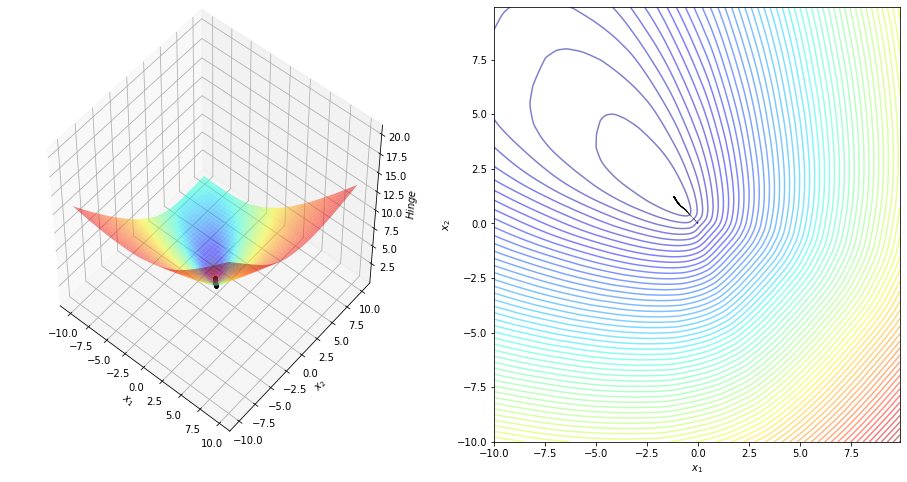

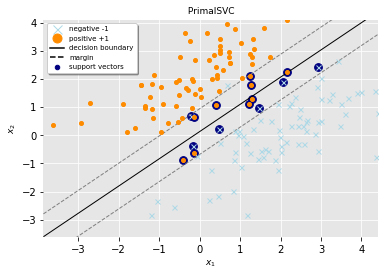

svc accuracy score is 1.0
svc w is [-1.1926757   1.23293793]
svc b is -0.16071656190986464

sklearn CPU times: user 788 µs, sys: 323 µs, total: 1.11 ms
Wall time: 1 ms


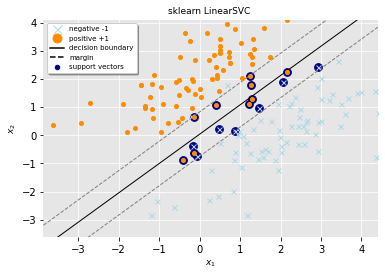

sklearn svc accuracy score is 1.0
sklearn svc w is [[-1.32079512  1.26735971]]
sklearn svc b is [-0.04826252]


In [8]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SKLinearSVC
from sklearn.model_selection import train_test_split

X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
%time svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='hinge')
print('sklearn ', end='')
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

Where the parameter $C$ controls the trade-off between the slack variable penalty and the size of the margin. Reformulating as a Lagrangian, which as before we need to minimize with respect to $w$, $b$ and $\xi_{i}$ and maximize with respect to $\alpha$ (where $\alpha_{i} \geq 0, \mu_{i} \geq 0 \ \forall_{i}$):

$$
\begin{equation}
    L_{P}\displaystyle = \frac{1}{2}\Vert w\Vert^{2}+C\sum_{i=1}^n\xi_{i}-\sum_{i=1}^n\alpha_{i}[y_{i}(\langle w, {x}_{i} \rangle+b)-1+\xi_{i}]-\sum_{i=1}^n\mu_{i}\xi_{i} \tag{2.6}
\end{equation}
$$

Differentiating with respect to $w$, $b$ and $\xi_{i}$ and setting the derivatives to zero:

$$
\begin{equation}
    \displaystyle \frac{\partial L_{P}}{\partial w}=0\Rightarrow w=\sum_{i=1}^{n}\alpha_{i}y_{i}x_i \tag{2.7}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial L_{P}}{\partial b}=0\Rightarrow\sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{2.8}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial L_{P}}{\partial\xi_{i}}=0\Rightarrow C=\alpha_{i}+\mu_{i} \tag{2.9}
\end{equation}
$$

Substituting these in, $L_{D}$ has the same form as (1.16) before. However (2.9) together with $\mu_{i}\geq 0 \ \forall_{i}$, implies that $\alpha\leq C$. We therefore need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha} \quad & \frac{1}{2}\alpha^{T}Q\alpha-q^T\alpha \\
            \textrm{subject to} \quad & 0\leq\alpha_{i}\leq C \ \forall_{i} \\ & y^T\alpha=0 
    \end{aligned} \tag{2.10}
\end{equation}
$$

where $q$ is a vector of all ones.

$b$ is then calculated in the same way as in (1.7) before, though in this instance the set of support vectors used to calculate $b$ is determined by finding the indices $i$ where $0\leq\alpha_{i}\leq C$.

iter	 cost
   0	-1.4804e+00
   1	-1.6193e+00
   2	-1.6204e+00
   3	-1.8862e+00
   4	-1.9004e+00
   5	-1.9032e+00
   6	-1.9035e+00
   7	-1.9244e+00
   8	-1.9259e+00
   9	-1.9259e+00
  10	-1.9260e+00
  11	-1.9260e+00
  12	-1.9261e+00
  13	-1.9261e+00
  14	-1.9262e+00
  15	-1.9262e+00
  16	-1.9263e+00
  17	-1.9264e+00
  18	-1.9264e+00
  19	-1.9265e+00
  20	-1.9265e+00
  21	-1.9266e+00
  22	-1.9266e+00

CPU times: user 217 ms, sys: 112 ms, total: 329 ms
Wall time: 56.8 ms


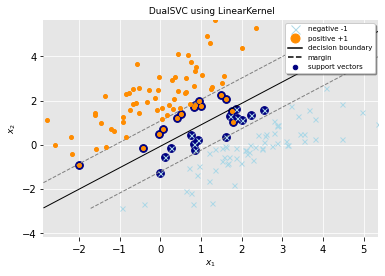

svc accuracy score is 1.0
svc found 28 support vectors from 150 examples
svc w is [-0.84757467  0.87297424]
svc b is 0.05751676544475624

sklearn CPU times: user 1.22 ms, sys: 579 µs, total: 1.8 ms
Wall time: 1.56 ms


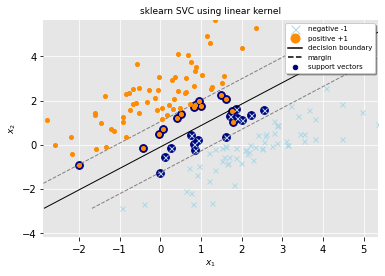

sklearn svc accuracy score is 0.98
sklearn svc found 28 support vectors from 150 examples
sklearn svc w is [[-0.84648604  0.87234545]]
sklearn svc b is [0.08506838]


In [5]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, C=0.1, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='linear', C=0.1)
print('sklearn ', end='')
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

epoch	iter	 cost	
   0	   0	-1.6915e+14	ub: -1.6915e+14 - pcost: -5.5021e+01 - gap:  1.0000e+00
   1	   1	 5.6514e+01	ub: -5.5021e+01 - pcost: -5.5021e+01 - gap:  0.0000e+00



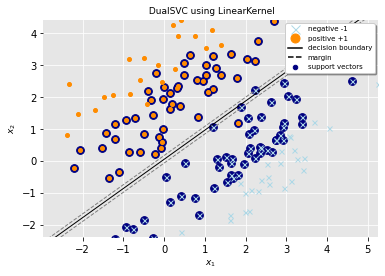

svc accuracy score is 0.94
svc found 102 support vectors from 150 examples
svc w is [-7.69200768  8.44248418]
svc b is -0.48800662248708393


In [3]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, C=0.1, optimizer=AdaGrad, verbose=True)
svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

### Support Vector Regression

Instead of attempting to classify new unseen variables $x'$ into one of two categories $y'=\pm 1$, we now wish to predict a real-valued output for $y'$ so that our training data is of the form:

$$
\{x_i,y_i\} \text{where i}=1, \dots, n, x\in\Re^{m}, y_{i}\in\Re
$$

The regression SVM will use a more sophisticated penalty function than before, not allocating a penalty if the predicted value $y'_{i}$ is less than a distance $\epsilon$ away from the actual value $y_{i}$, i.e., if $|y_{i}-y'_{i}|<\epsilon$. 

<img src="./img/svr.png" width=600/>

Referring to this figure, the region bound by $y'_{i}\pm\epsilon \ \forall_{i}$ is called an $\epsilon$-insensitive tube. The other modification to the penalty function is that output variables which are outside the tube are given one of two slack variable penalties depending on whether they lie above $(\xi^{+})$ or below $(\xi^{-})$ the tube (where $\xi^{+} \geq 0, \xi^{-} \geq 0 \ \forall_{i}$):

$$
\begin{equation}
    y_{i}\leq y'_{i}+\epsilon+\xi^{+} \tag{3.1}
\end{equation}
$$
$$
\begin{equation}
    y_{i}\geq y'_{i}-\epsilon-\xi^{-} \tag{3.2}
\end{equation}
$$

The error function for SVM regression can then be written as:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b,\xi^{+},\xi^{-}} \quad & \frac{1}{2}\Vert w\Vert^{2} + C \sum_{i=1}^{n}(\xi_{i}^{+}+\xi_{i}^{-}) \\
            \textrm{subject to} \quad & y_{i} - \langle w, x_i \rangle - b \leq \epsilon + \xi_{i}^{+} \ \forall_{i} \\ & \langle w, x_i \rangle + b - y_{i} \leq \epsilon + \xi_{i}^{-} \ \forall_{i} \\ & \xi_{i}^{+}, \xi_{i}^{-} \geq 0 \ \forall_{i}
    \end{aligned} \tag{3.3}
\end{equation}
$$

which can be equivalently formulated as: 

$$
\begin{equation}
    \min_ {w, b} \frac{1}{2} \Vert w\Vert^{2} + C 
        \begin{cases}
            \sum_{i=1}^n \max(0, |y_i - (\langle w, x_i \rangle + b)| - \epsilon) & \text{if using L1 loss} \\
            \sum_{i=1}^n \max(0, |y_i - (\langle w, x_i \rangle + b)| - \epsilon)^2 & \text{if using L2 loss}
          \end{cases} \tag{3.4}
\end{equation}
$$

where we make use of the epsilon-insensitive (L1 loss) and squared epsilon-insensitive (L2 loss) loss respectively, i.e., errors of less than $\epsilon$ are ignored.

epoch	iter	 cost	
   0	   0	 4.7343e+01 - val_loss:  6.6203e+01 - r2: -0.0121
  50	  50	 3.7148e+01 - val_loss:  6.3653e+01 - r2:  0.4588
 100	 100	 3.3133e+01 - val_loss:  7.4627e+01 - r2:  0.6338
 150	 150	 3.1026e+01 - val_loss:  8.6643e+01 - r2:  0.7328
 200	 200	 2.9730e+01 - val_loss:  9.8417e+01 - r2:  0.7983
 250	 250	 2.8895e+01 - val_loss:  1.0959e+02 - r2:  0.8447
 300	 300	 2.8346e+01 - val_loss:  1.2004e+02 - r2:  0.8787
 350	 350	 2.7978e+01 - val_loss:  1.2972e+02 - r2:  0.9042
 400	 400	 2.7739e+01 - val_loss:  1.3864e+02 - r2:  0.9236
 450	 450	 2.7584e+01 - val_loss:  1.4682e+02 - r2:  0.9386
 500	 500	 2.7489e+01 - val_loss:  1.5429e+02 - r2:  0.9503
 550	 550	 2.7436e+01 - val_loss:  1.6110e+02 - r2:  0.9594
 600	 600	 2.7412e+01 - val_loss:  1.6730e+02 - r2:  0.9666
 650	 650	 2.7410e+01 - val_loss:  1.7293e+02 - r2:  0.9723
 700	 700	 2.7422e+01 - val_loss:  1.7803e+02 - r2:  0.9768
 750	 750	 2.7448e+01 - val_loss:  1.8263e+02 - r2:  0.9804
 800	 800	 2.7496e+01 

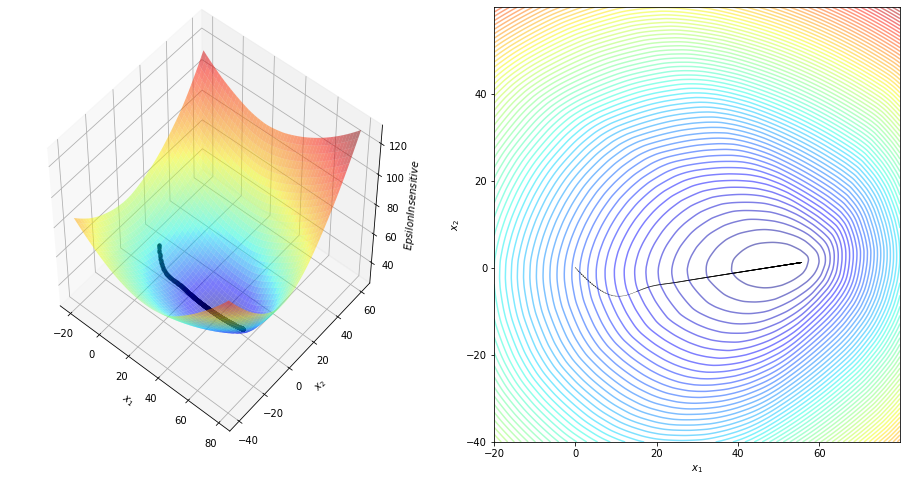

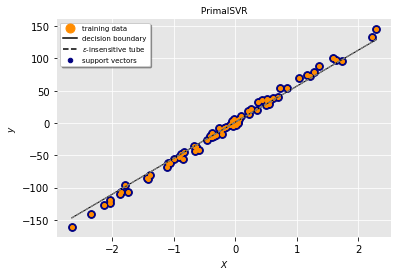

svr accuracy score is 0.9908261260074576
svr w is [55.6957389]
svr b is 1.245416861902405

sklearn CPU times: user 897 µs, sys: 0 ns, total: 897 µs
Wall time: 806 µs


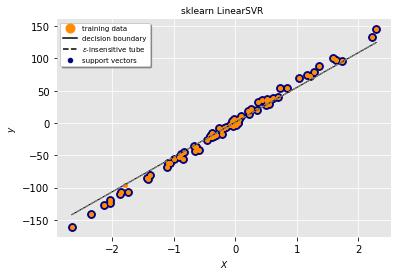

sklearn svr accuracy score is 0.9847700739392456
sklearn svr w is [53.79651347]
sklearn svr b is [1.1529981]


In [21]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVR as SKLinearSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = PrimalSVR(loss=epsilon_insensitive, epsilon=0.1, optimizer=AdaGrad, 
                learning_rate_init=0.15, momentum_type='nesterov', 
                early_stopping=False, validation_split=0.1, verbose=50)
%time svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, -20, 80, -40, 60)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr accuracy score is {svr.score(X_test, y_test)}')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SKLinearSVR(loss='epsilon_insensitive', epsilon=0.1)
print('sklearn ', end='')
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr accuracy score is {svr.score(X_test, y_test)}')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

This needs to be minimized subject to the constraints $\xi^{+}\geq 0, \xi^{-}\geq 0 \ \forall_{i}$ and (3.1) and (3.2). In order to do this we introduce Lagrange multipliers $\alpha_{i}^{+}\geq 0, \alpha_{i}^{-}\geq 0, \mu_{i}^{+}\geq 0\mu_{i}^{-}\geq 0 \ \forall_{i}$:

$$
\begin{equation}
    \displaystyle L_{P}=\frac{1}{2}\Vert w\Vert^{2}+C \sum_{i=1}^n(\xi_{i}^{+}+\xi_{i}^{-})-\sum_{i=1}^n(\mu_{i}^{+}\xi_{i}^{+}+\mu_{i}^{-}\xi_{i}^{-})-\sum_{i=1}^n\alpha_{i}^{+}(\epsilon+\xi_{i}^{+}+y'_{i}-y_{i})-\sum_{i=1}^n\alpha_{i}^{-}(\epsilon+\xi_{i}^{-}-y'_{i}+y_{i}) \tag{3.5}
\end{equation}
$$

Substituting for $y_{i}$, differentiating with respect to $w, b, \xi^{+}$ and $\xi^{-}$ and setting the derivatives to $0$:

$$
\begin{equation}
    \displaystyle \frac{\partial L_{P}}{\partial w}=0\Rightarrow w=\sum_{i=1}^{n}(\alpha_{i}^{+}-\alpha_{i}^{-})x_{i} \tag{3.6}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial L_{P}}{\partial b}=0\Rightarrow \sum_{i=1}^{n}(\alpha_{i}^{+}-\alpha_{i}^{-})=0 \tag{3.7}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial L_{P}}{\partial\xi_{i}^{+}}=0\Rightarrow C=\alpha_{i}^{+}+\mu_{i}^{+} \tag{3.8}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial L_{P}}{\partial\xi_{i}^{-}}=0\Rightarrow C=\alpha_{i}^{-}+\mu_{i}^{-} \tag{3.9}
\end{equation}
$$

Substituting (3.6) and (3.7) in, we now need to maximize $L_{D}$ with respect to $\alpha_{i}^{+}$ and $\alpha_{i}^{-}(\alpha_{i}^{+}\geq 0,\ \alpha_{i}^{-}\geq 0 \ \forall_{i})$ where:

$$
\begin{equation}
    L_{D}=\displaystyle \sum_{i=1}^{n}y_{i}(\alpha_{i}^{+}-\alpha_{i}^{-})-\epsilon\sum_{i=1}^{n}(\alpha_{i}^{+}+\alpha_{i}^{-})-\frac{1}{2}\sum_{i,j}(\alpha_{i}^{+}-\alpha_{i}^{-})\langle x_i, x_j \rangle(\alpha_{j}^{+}-\alpha_{j}^{-}) \tag{3.10}
\end{equation}
$$

Using $\mu_{i}^{+}\geq 0$ and $\mu_{i}^{-}\geq 0$ together with (3.8) and (3.9) means that $\alpha_{i}^{+}\leq C$ and $\alpha_{i}^{-}\leq C$. We therefore need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha^+,\alpha^-} \quad & \frac{1}{2}(\alpha^{+}-\alpha^{-})^TQ(\alpha^{+}-\alpha^{-})+\epsilon q^T(\alpha^{+}+\alpha^{-})-y^T(\alpha^{+}-\alpha^{-}) \\
            \textrm{subject to} \quad & 0\leq\alpha_{i}^{+},\alpha_{i}^{-}\leq C \ \forall_{i} \\ & q^T(\alpha^{+}-\alpha^{-})=0
    \end{aligned} \tag{3.11}
\end{equation}
$$

where $q$ is a vector of all ones.

Each new predictions $y'$ can be found using:

$$
\begin{equation}
    y'=\displaystyle \sum_{i=1}^{n}(\alpha_{i}^{+}-\alpha_{i}^{-})\langle x_{i}, x' \rangle+b \tag{3.12}
\end{equation}
$$

A set $S$ of Support Vectors $x_{s}$ can be created by finding the indices $i$ where $0\leq\alpha\leq C$ and $\xi_{i}^{+}=0$ (or $\xi_{i}^{-}=0$).

This gives us:

$$
\begin{equation}
    b=y_{s}-\displaystyle \epsilon-\sum_{m\in S}(\alpha_m^+ -\alpha_m^-) \langle x_{m}, x_{s} \rangle \tag{3.13}
\end{equation}
$$

As before it is better to average over all the indices $i$ in $S$:

$$
\begin{equation}
    b=\displaystyle \frac{1}{N_{s}}\sum_{s\in S}y_{s}-\epsilon-\sum_{m\in S}(\alpha_{m}^{+}-\alpha_{m}^{-})\langle x_{m}, x_{s} \rangle \tag{3.14}
\end{equation}
$$

iter	 cost
   0	-1.8569e+03
   1	-1.8569e+03
   2	-1.9000e+03
   3	-1.9006e+03
   4	-1.9007e+03
   5	-1.9015e+03
   6	-1.9017e+03
   7	-1.9017e+03
   8	-1.9018e+03
   9	-1.9019e+03
  10	-1.9019e+03
  11	-1.9020e+03
  12	-1.9020e+03
  13	-1.9021e+03
  14	-1.9021e+03
  15	-1.9021e+03
  16	-1.9021e+03

CPU times: user 126 ms, sys: 113 ms, total: 239 ms
Wall time: 38.1 ms


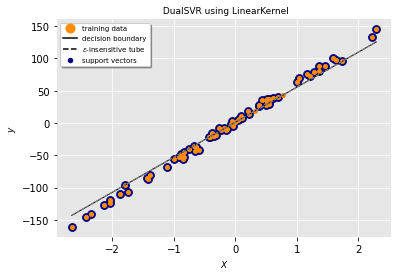

svr accuracy score is 0.9821620879329686
svr w is [54.19365357]
svr b is 1.1553142357447785

sklearn CPU times: user 845 µs, sys: 549 µs, total: 1.39 ms
Wall time: 808 µs


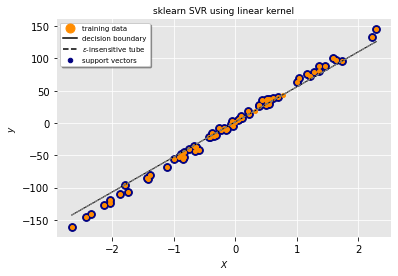

sklearn svr accuracy score is 0.9826031832241807
sklearn svr w is [[54.19365413]]
sklearn svr b is [1.68412692]


In [13]:
from optiml.ml.svm import DualSVR
from optiml.ml.utils import plot_svm_hyperplane

from sklearn.svm import SVR as SKLSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=linear, epsilon=0.1, verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr accuracy score is {svr.score(X_test, y_test)}')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SKLSVR(kernel='linear', epsilon=0.1)
print('sklearn ', end='')
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr accuracy score is {svr.score(X_test, y_test)}')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

epoch	iter	 cost	
   0	   0	 3.2693e+23	ub:  3.2693e+23 - pcost: -1.9016e+02 - gap: -1.0000e+00

CPU times: user 61.8 ms, sys: 68.7 ms, total: 130 ms
Wall time: 21.1 ms


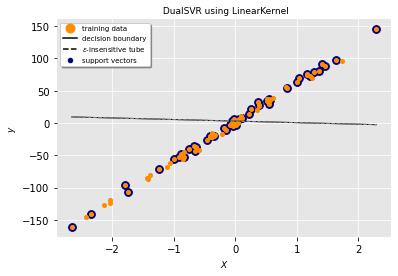

svr accuracy score is -0.08518166464829013
svr w is [-2.42070671]
svr b is 2.960877695125122


In [15]:
from optiml.ml.svm import DualSVR
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=linear, epsilon=0.1, optimizer=AdaGrad, verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr accuracy score is {svr.score(X_test, y_test)}')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

### Nonlinear Support Vector Machines

When applying our SVM to linearly separable data we have started by creating a matrix $Q$ from the dot product of our input variables:

$$ Q_{ij}=y_{i}y_{j}k(x_{i},\ x_{j})= \langle x_{i}, x_{j} \rangle=x_{i}^{T}x_{j} $$

$k(x_{i},x_{j})$ is an example of a family of functions called *kernel functions* where $k(x_{i},x_{j})=\langle x_{i}, x_{j} \rangle$ being known as a *linear* kernel. The set of kernel functions is composed of variants of (3.1) in that they are all based on calculating inner products of two vectors. This means that if the functions can be recast into a higher dimensionality space by some potentially nonlinear feature mapping function $x\rightarrow \phi(x)$, only inner products of the mapped inputs in the feature space need be determined without us needing to explicitly calculate $\phi$.

The reason that this *kernel trick* is useful is that there are many classification/regression problems that are not linearly separable/regressable in the space of the inputs $x$, which might be in a higher dimensionality feature space given a suitable mapping $x \rightarrow \phi(x)$.

#### Polynomial Kernel

The *polynomial* kernel is defined as:

$$k(x_{i},x_{j})=(\gamma \langle x_i, x_j\rangle + r)^d$$

where $\gamma$ define how far the influence of a single training example reaches (low values meaning ‘far’ and high values meaning ‘close’) and is specified by keyword *gamma*, $d$ by *degree* and $r$ by *coef0*.

iter	 cost
   0	-3.4698e-02
   3	-5.4247e-02
   6	-6.1686e-02
   9	-6.2443e-02
  12	-6.3777e-02
  15	-6.3779e-02
  18	-6.3781e-02
  21	-6.3782e-02
  24	-6.3783e-02
  27	-6.3783e-02

CPU times: user 501 ms, sys: 520 ms, total: 1.02 s
Wall time: 187 ms


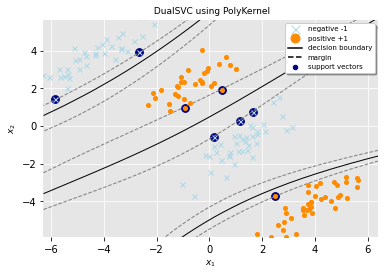

svc accuracy score is 0.96
svc found 8 support vectors from 150 examples
svc b is -0.4288973037718965

sklearn CPU times: user 873 µs, sys: 594 µs, total: 1.47 ms
Wall time: 983 µs


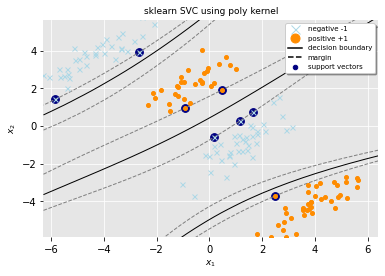

sklearn svc accuracy score is 0.96
sklearn svc found 8 support vectors from 150 examples
sklearn svc b is [-0.38078735]


In [7]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), verbose=3)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='poly', degree=3, coef0=3, gamma='auto')
print('sklearn ', end='')
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

epoch	iter	 cost	
   0	   0	-3.7687e+11	ub: -3.7687e+11 - pcost: -2.5752e+06 - gap:  9.9999e-01
   1	   1	 2.5752e+06	ub: -2.5752e+06 - pcost: -2.5752e+06 - gap:  0.0000e+00

CPU times: user 146 ms, sys: 177 ms, total: 323 ms
Wall time: 49.5 ms


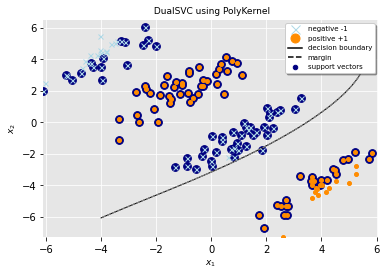

svc accuracy score is 0.84
svc found 120 support vectors from 150 examples
svc b is -19602.66937508887


In [4]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), optimizer=AdaGrad, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

#### Gaussian RBF Kernel

The *gaussian* kernel is defined as:

$$k(x_{i},x_{j})=\exp(-\frac{\|x_i-x_j\|^2}{2\sigma^2})$$

or, equivalently, as:

$$k(x_{i},x_{j})=\exp(-\gamma \|x_i-x_j\|^2)$$

where $\displaystyle \gamma=\frac{1}{2\sigma^2}$ define how far the influence of a single training example reaches (low values meaning ‘far’ and high values meaning ‘close’) and is specified by keyword *gamma*.

iter	 cost
   0	-7.6965e+00
   1	-7.9969e+00
   2	-8.0748e+00
   3	-8.0846e+00
   4	-8.0880e+00
   5	-8.0909e+00
   6	-8.0923e+00
   7	-8.0930e+00
   8	-8.0930e+00
   9	-8.0930e+00
  10	-8.0930e+00
  11	-8.8691e+00
  12	-8.9418e+00
  13	-8.9695e+00
  14	-8.9804e+00
  15	-8.9890e+00
  16	-8.9930e+00
  17	-8.9937e+00
  18	-8.9944e+00
  19	-8.9946e+00
  20	-8.9947e+00
  21	-8.9947e+00
  22	-8.9947e+00

CPU times: user 2.13 s, sys: 1.96 s, total: 4.09 s
Wall time: 617 ms


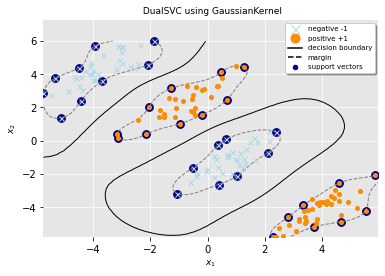

svc accuracy score is 1.0
svc found 36 support vectors from 150 examples
svc b is 0.03596378908105798

sklearn CPU times: user 980 µs, sys: 692 µs, total: 1.67 ms
Wall time: 1.49 ms


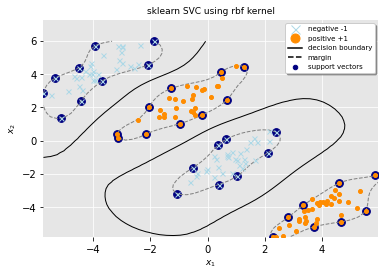

sklearn svc accuracy score is 1.0
sklearn svc found 36 support vectors from 150 examples
sklearn svc b is [0.0350255]


In [9]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='rbf', gamma='auto')
print('sklearn ', end='')
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

epoch	iter	 cost	
   0	   0	-9.1819e+01	ub: -9.1819e+01 - pcost: -2.1479e+02 - gap: -1.3393e+00

CPU times: user 50.1 ms, sys: 70.6 ms, total: 121 ms
Wall time: 21.6 ms


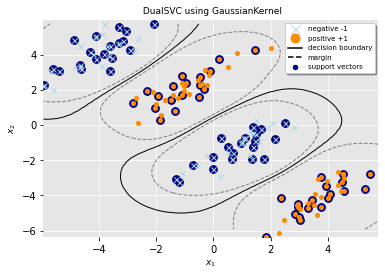

svc accuracy score is 1.0
svc found 77 support vectors from 150 examples
svc b is 0.19404435895078395


In [10]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), optimizer=AdaGrad, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

iter	 cost
   0	-5.6807e-01
   2	-6.0011e-01
   4	-6.1199e-01
   6	-6.1312e-01
   8	-6.1326e-01
  10	-6.4448e-01
  12	-6.8078e-01
  14	-6.9358e-01
  16	-6.9382e-01
  18	-7.0382e-01
  20	-7.0631e-01
  22	-7.0717e-01
  24	-7.0780e-01
  26	-7.0783e-01
  28	-7.0784e-01
  30	-7.1042e-01
  32	-7.1057e-01
  34	-7.1058e-01

CPU times: user 809 ms, sys: 623 ms, total: 1.43 s
Wall time: 220 ms


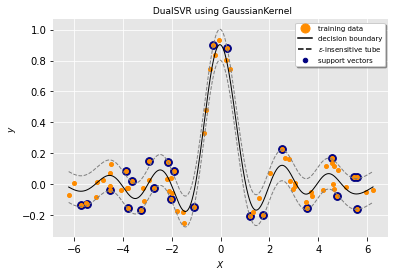

svr r2 score is 0.7572860923104933
svr found 24 support vectors from 75 examples
svr b is 0.06345332656322962

sklearn CPU times: user 838 µs, sys: 590 µs, total: 1.43 ms
Wall time: 833 µs


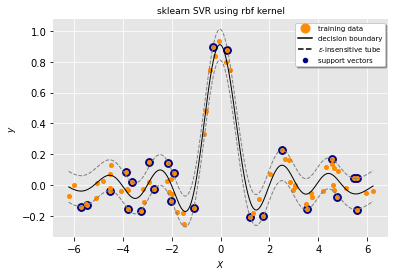

sklearn svr r2 score is 0.7423481683232758
sklearn svr found 24 support vectors from 75 examples
sklearn svr b is [0.07199126]


In [11]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SKLSVR
from sklearn.model_selection import train_test_split

X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), verbose=2)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = SKLSVR(kernel='rbf', gamma='auto')
print('sklearn ', end='')
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')